# A/B Test — Subscription Conversion Optimization

### Author: Svitlana Prasolova

# Project Description
#### Goal: To determine whether emphasizing a “50% discount” message on the subscription screen increases purchase conversion compared to the standard $4.99 offer.
The experiment was conducted to evaluate the impact of visual pricing cues on user conversion.
Two user groups participated: 
- Group A (Control): Standard $4.99 subscription screen;
- Group B (Variant): Same $4.99 offer labeled as '50% discount'.

## Project Task:
- Design and run an A/B test on the subscription screen.
- Compare user conversion between control (A) and variant (B) groups.
- Evaluate statistical significance using a hypothesis test.
- Visualize conversion rates with 95% confidence intervals.
- Draw business conclusions and decide on rollout.

## Results
The A/B test ran for 21 days (July 3–25, 2023) and revealed a significant uplift in conversion for the variant with the “50% discount” label.
- Group A: 6.10% conversion
- Group B: 8.90% conversion
- t-statistic = −7.53, p-value ≈ 0.0 → significant at α = 0.05
The discount design consistently outperformed the control version across the entire test period.
### Conclusion:
Highlighting a “50% discount” on the subscription screen significantly increased conversions. The result is statistically robust and stable over time.

# Process
### Preparing work environment
I will be using Python for the data transformation and research. The following libraries are installed:

In [4]:
import pandas as pd
import numpy as np

df_AB_testing = pd.read_csv(r"C:\Users\Світлана\Pictures\Data analuzes\A-B testing\_ab_test_data.csv")
df_AB_testing.head()                                      # Verifying the data

,user_id,timestamp,test_group,conversion
0,7f6833e6-1141-4f20-b4b2-f1e31019b1fd,2023-07-04 04:40:55.848109,a,0
1,e6a6e960-d3f3-4074-a516-ba1e609b211e,2023-07-06 00:26:45.486187,b,0
2,4d3fbfa5-6847-410a-bac2-477f01d5f400,2023-07-10 20:24:33.639464,b,0
3,361457d9-a044-48f7-981c-d67dc3861679,2023-07-20 07:04:49.957013,b,0
4,285cd63d-7d03-427f-a062-1fa2dd2e77d6,2023-07-19 23:27:50.116680,b,0


In [5]:
df_AB_testing.info()                                 # Data quality check

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19998 entries, 0 to 19997
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     19998 non-null  object
 1   timestamp   19998 non-null  object
 2   test_group  19998 non-null  object
 3   conversion  19998 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 625.1+ KB


In [6]:
df_AB_testing.isnull().sum()                           # Data quality check

user_id       0
timestamp     0
test_group    0
conversion    0
dtype: int64

# Output information about the results of the A/B test:
#### 1. Number of users in groups A and B, respectively

In [7]:
number_AB_testing = (                    #Pre-grouping test_group to determine the number of users in groups A and B, respectively
    df_AB_testing
    .groupby(["test_group"])
    .agg(number_user_id=('user_id', 'count'))
    .reset_index()
)

number_AB_testing.head()

,test_group,number_user_id
0,a,10013
1,b,9985


In [8]:
group_count = df_AB_testing['test_group'].value_counts()  
group_percent = df_AB_testing['test_group'].value_counts(normalize=True) * 100

df_group = pd.DataFrame({
    'test_group': group_count.index,
    'users': group_count.values,
    'percent': group_percent.values
})

df_group                                              # The distribution of test groups (A/B) is determined as normal (almost 50/50)

,test_group,users,percent
0,a,10013,50.070007
1,b,9985,49.929993


#### 2. Number of conversions in groups A and B respectively

In [9]:
result_AB_testing = (                    #Pre-grouping test_group to determine the number of conversions in groups A and B, respectively
    df_AB_testing
    .groupby(["test_group"])
    .agg(total_conversion=('conversion', 'sum'))
    .reset_index()
)

result_AB_testing.head()

,test_group,total_conversion
0,a,611
1,b,889


#### 3. Determining the conversion rate in groups A and B respectively

In [10]:
CR_AB_testing = (                    # Taking into account previous groupings test_group and determining the conversion rate (CR) in groups A and B, respectively
    df_AB_testing
    .groupby(["test_group"], as_index=False)
    .agg(number_user_id=('user_id', 'count'),
        total_conversion=('conversion', 'sum') 
        )   
    )
# Now we add a column with CR (Conversion Rate)
CR_AB_testing["CR"] = CR_AB_testing["total_conversion"] / CR_AB_testing["number_user_id"] * 100
CR_AB_testing.head()

,test_group,number_user_id,total_conversion,CR
0,a,10013,611,6.102067
1,b,9985,889,8.903355


#### 4. Defining the start and end dates of the test, as well as the duration of the test in days

In [11]:
df_AB_testing['timestamp'] = pd.to_datetime(df_AB_testing['timestamp'])  # Converting date data_type from 'object' type directly to 'timestamp'

In [12]:
# Find the start date and end date of the test
start_date = df_AB_testing['timestamp'].min()
end_date = df_AB_testing['timestamp'].max()

#Calculate the test duration in days
test_duration = (end_date - start_date).days

print(f"Test start date: {start_date.date()}")
print(f"Test completion date: {end_date.date()}")
print(f"Test duration: {test_duration} days")

Test start date: 2023-07-03
Test completion date: 2023-07-25
Test duration: 21 days


### II. We choose a statistical criterion for hypothesis testing and calculate the statistical value and p-value.

In [13]:
 # Checking statistics by group
df_AB_testing.groupby('test_group')['conversion'].describe()

,count,mean,std,min,25%,50%,75%,max
test_group,,,,,,,,
a,10013.0,0.061021,0.239380,0.0,0.0,0.0,0.0,1.0
b,9985.0,0.089034,0.284806,0.0,0.0,0.0,0.0,1.0


In [14]:
# Since in point 1 the distribution of test groups (A/B) is defined as normal, we use the Student's t-test to test hypotheses:
from scipy import stats

alpha = 0.05

statistic, pvalue = stats.ttest_ind(df_AB_testing[df_AB_testing['test_group'] == 'a']['conversion'],
                                    df_AB_testing[df_AB_testing['test_group'] == 'b']['conversion'], 
                                    alternative='less')

print(f't-statistic: {round(statistic, 2)}, p-value: {round(pvalue, 2)}')

if pvalue < alpha:
    print('The difference is statistically significant, Null Hypothesis is rejected.')
else:
    print('The difference is insignificant, Null Hypothesis cannot rejected.')

t-statistic: -7.53, p-value: 0.0
The difference is statistically significant, Null Hypothesis is rejected.


In [15]:
def statistic(a, b):
    return stats.ttest_ind(a, b).statistic          # We check the statistical significance of the obtained results using permutation tests in SciPy

alpha = 0.05
    
a = df_AB_testing[df_AB_testing['test_group'] == 'a']['conversion']
b = df_AB_testing[df_AB_testing['test_group'] == 'b']['conversion'] 

result = stats.permutation_test((a, b), statistic, n_resamples=10000)

print(f'statistic: {result.statistic}, p-value: {result.pvalue}')

if result.pvalue < alpha:
    print('The difference is statistically significant, Null Hypothesis is rejected.')
else:
    print('The difference is insignificant, Null Hypothesis cannot rejected.')

statistic: -7.5299531387344185, p-value: 0.00019998000199980003
The difference is statistically significant, Null Hypothesis is rejected.


#### Conclusion:
###### Null hypothesis (H₀): There is no difference in conversion between groups A and B (p-value: 0.00).
##### Alternative hypothesis (H₁): Conversion in group B is higher than in group A (because alternative='less' - statistic: -7.529).
That is, users who saw the "50% off" offer have a statistically higher conversion than those who were shown the $4.99 price without the discount.
##### From a business point of view:
- The "50% off" offer significantly increases the likelihood of purchasing a subscription.
- The difference is not random (p-value ≈ 0), i.e. the result is reliable.
- Thus, the test should be considered successful - option B demonstrates a more effective conversion of visitors into buyers.

### III. Visualization for comparing means in groups with 95% confidence intervals

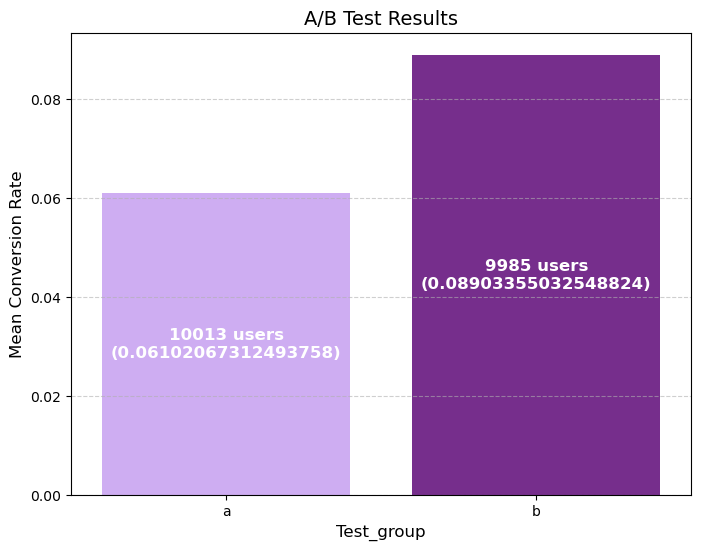

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

summary = (                                       # Aggregation of data for each group A and B
    df_AB_testing
    .groupby('test_group', as_index=False)
    .agg(conversion=('conversion', 'mean'),
         count=('user_id', 'count'))  
)

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=summary,
    x='test_group',
    y='conversion',
    hue='test_group',                          # add hue
    errorbar=('ci', 95),                       # 95% confidence intervals
    palette={'a': '#cea2fd', 'b': '#7e1e9c'},  # Setting custom colors for barplot
    legend=False                               # we turn off the legend because it duplicates the X-axis labels
)
for i, row in summary.iterrows():
    ax.text(i,                                              # position on X
        row['conversion']/2,                                # insert signatures in the middle of the column
        f"{row['count']} users\n({row['conversion']})",     # signature format
        ha='center', va='center',
        color='white', fontsize=12, weight='bold'
    )
    
plt.title('A/B Test Results', fontsize=14)
plt.xlabel('Test_group', fontsize=12)
plt.ylabel('Mean Conversion Rate', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

#### Conversion dynamics over time (barplot by date):

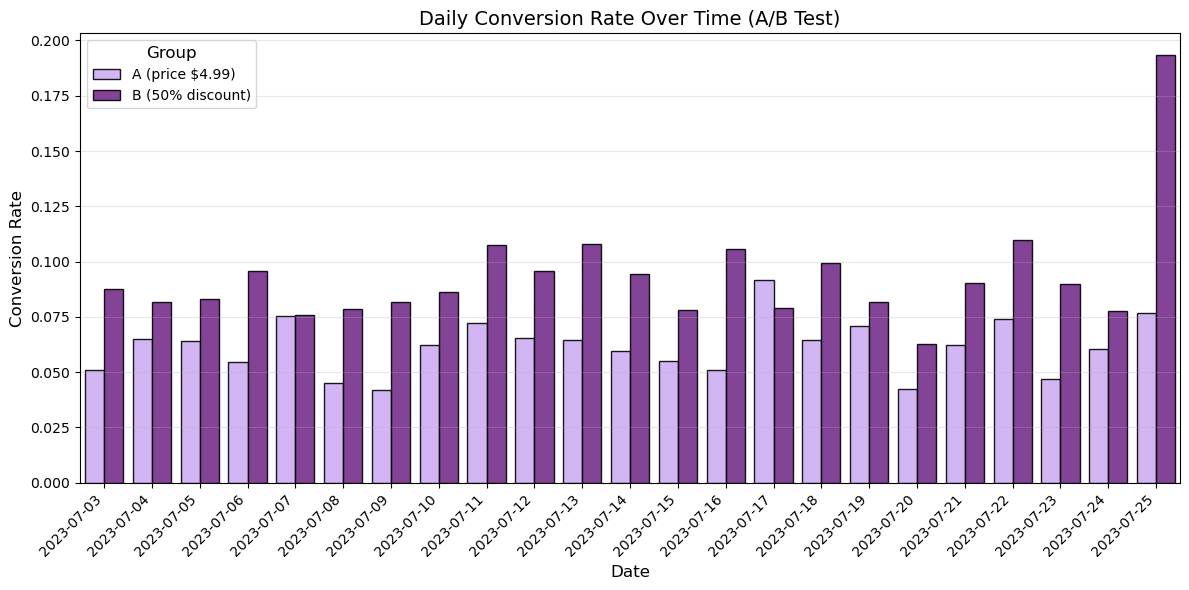

In [17]:
# Let's create a new column with the date (without the time)
df_AB_testing['date'] = df_AB_testing['timestamp'].dt.date

# Replace group designations for correct display in the legend
df_AB_testing['test_group'] = df_AB_testing['test_group'].replace({
    'a': 'A (price $4.99)',
    'b': 'B (50% discount)'
})

# We calculate daily conversion for each group
conversion_by_date = (
    df_AB_testing
    .groupby(['date', 'test_group'])
    .agg(conversion_rate=('conversion', 'mean'))
    .reset_index()
)
# Graph construction
plt.figure(figsize=(12, 6))
sns.barplot(
    data=conversion_by_date,
    x='date',
    y='conversion_rate',
    hue='test_group',
    palette={
        'A (price $4.99)': '#cea2fd', 
        'B (50% discount)': '#7e1e9c'
    },
    edgecolor='black',
    alpha=0.9
)
# Design
plt.title('Daily Conversion Rate Over Time (A/B Test)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Group', title_fontsize=12)
plt.tight_layout()
plt.show()

### Conclusions about the A/B test results:
#### Context:
The goal of the A/B test was to determine whether a 50% discount (group B) affects the conversion rate of users compared to the standard price of $4.99 (group A).
The test was conducted for 21 days: from 2023-07-03 to 2023-07-25,
the data contains the timestamp of each event (timestamp)
and the fact of performing the target action (conversion = 1/0).
##### Data validity check:
- The data type by dates was converted to datetime format, which allowed tracking the change in conversion over time.
- The average conversion level in groups A and B was calculated for each day.
- The visualization showed stable user activity throughout the testing period without significant gaps in the data.

#### Statistical analysis
To test the hypothesis, we used a Student's t-test for independent samples with the alternative 'less' (i.e., the hypothesis that the conversion of group A < the conversion of group B):
###### Test results: t-statistic = −7.53; p-value ≈ 0.0
###### Interpretation: Since the p-value < 0.05 (α = 0.05), we reject the null hypothesis.
This means that the difference between the average conversion rates is statistically significant - users in group B (with a 50% discount) made purchases significantly more often than users in group A (regular price $4.99).
#### Visualization of results:
###### 1. Comparison of average conversion by groups (barplot):
Group A has a lower average conversion (6.102%),
while B (purple, demonstrates a significantly higher conversion rate (8.903%).
###### 2. Conversion dynamics over time (barplot by date):
- Conversion in group B remained higher almost throughout the entire test period.
- On some days (07/25/2023), there is an increase in the gap between the groups, which confirms the stability of the discount effect.
- Both curves do not intersect, which visually confirms the statistical conclusion.

### Key findings:
| Metric          | Group A ($4.99)            | Group B (50% discount)                 |
| --------------- | -------------------------- | -------------------------------------- |
| Users           | 10,013                     | 9,985                                  |
| Conversions     | 611                        | 889                                    |
| Conversion Rate | **6.1%**                   | **8.9%**                               |
| t-statistic     | −7.53                      |                                        |
| p-value         | 0.00                       |                                        |
| Result          | ❌ Null hypothesis rejected | ✅ Statistically significant difference |


#### Conclusion:
The introduction of a 50% discount led to a significant increase in conversions.
The effect is statistically significant and stable over time.
#### Recommendations:
- Decide to implement the discount model (group B) as the main pricing policy for this user segment.
- Conduct additional profitability analysis: although conversion has increased, it is important to check whether the increase in the number of purchases compensates for the loss of revenue due to the reduced price.
- If necessary, test smaller discounts (for example, 30% or 20%) to find the optimal balance between sales volume and margin.